# Categorical Embedding

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import functools

from keras import backend as K
from itertools import chain
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.metrics import top_k_categorical_accuracy
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input, Embedding,Reshape, Concatenate, Conv1D, BatchNormalization, GlobalMaxPooling1D, MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score

In [2]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
	raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data

In [3]:
data = pd.read_csv("./data/splited_full_RASFF_DATA.csv", sep=";", header=0, index_col=0)
data = data.sample(frac=1)

data.head(1)

,DATE_CASE,NOT_COUNTRY,PROD_CAT,TYPE,RISK_DECISION,ACTION_TAKEN,DISTRIBUTION_STAT,HAZARDS_CAT,COUNT_ORIGEN,COUNT_DESTIN,COUNT_CONCERN
17578,2019-07-24,Germany,"nuts, nut products and seeds",food,serious,informing authorities,distribution restricted to notifying country,pathogenic micro-organisms,United States,Germany,INFOSAN


In [4]:
class Stage:
	def __init__(self, input, output):
		self.input = input
		self.output = output

		self.x = data.iloc[:, input]
		self.y = data.iloc[:, output]

		self.x_train, self.y_train = None, None
		self.x_val, self.y_val = None, None
		self.x_test, self.y_test = None, None

		self.__transform()

	def __transform(self):
		strategy_x = OneHotEncoder(handle_unknown="ignore", sparse=False)
		strategy_y = OneHotEncoder(handle_unknown="ignore", sparse=False)

		strategy_x.fit(self.x.values)
		strategy_y.fit(self.y.values)

		self.x = strategy_x.transform(self.x.values)
		self.y = strategy_y.transform(self.y.values)

		self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.2)
		self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x_train, self.y_train, test_size=0.25, random_state=42, shuffle=True)

	def get_metrics(self):
		result = model.predict(self.x_test, batch_size=64)
		result = np.argmax(result, axis=-1)

		print(f"- Accuracy: {round(accuracy_score(np.argmax(self.y_test, axis=-1), result)*100, 2)}%")
		print(f"- Specifity: {round(get_specifity(np.argmax(self.y_test, axis=-1), result)*100, 2)}%")
		print(f"- Sensitivity: {round(recall_score(np.argmax(self.y_test, axis=-1), result, average='macro', zero_division=0)*100, 2)}%")
		print(f"- Precision: {round(precision_score(np.argmax(self.y_test, axis=-1), result, average='macro', zero_division=0)*100, 2)}%")

		print(classification_report(np.argmax(self.y_test, axis=-1), result, zero_division=True))

		cm = confusion_matrix(np.argmax(self.y_test, axis=-1), result)
		cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(0, cm.shape[0])))

		_, ax = plt.subplots(figsize=(10, 10))
		cm.plot(ax=ax)

		plt.show()

## Preprocessing

In [5]:
data.DATE_CASE = data.DATE_CASE.astype(str)
data.HAZARDS_CAT = data.HAZARDS_CAT.astype(str)
data.COUNT_DESTIN = data.COUNT_DESTIN.astype(str)
data.COUNT_CONCERN = data.COUNT_CONCERN.astype(str)

data = data.dropna(subset=['DATE_CASE'])

In [6]:
def get_specifity(y_actual, y_pred):
    TN = []
    FP = []

    for index ,_id in enumerate(np.union1d(y_actual, y_pred)):
        FP.append(0)
        TN.append(0)

        for i in range(len(y_pred)):
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1

    TN = sum(TN)
    FP = sum(FP)

    return TN/(TN + FP)

## Data Mining

In [7]:
stage1 = Stage(
	input=[0, 1, 6, 8],
	output=[2]
)

In [33]:
K.clear_session()

model = Sequential()
model.add(Dense(2048, activation="relu", input_dim=len(stage1.x_train[1].toarray().flatten())))
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(43, activation = "softmax"))

In [34]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              12394496  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 43)                2

In [ ]:
hist = model.fit(stage1.x_train ,stage1.y_train, epochs=170, validation_data=(stage1.x_val, stage1.y_val), batch_size=500)

Epoch 1/170


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 2048), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


202/202 [==============================] - 9s 29ms/step - loss: 1.8541 - categorical_accuracy: 0.5049 - val_loss: 1.1571 - val_categorical_accuracy: 0.6908
Epoch 2/170
202/202 [==============================] - 6s 27ms/step - loss: 0.9010 - categorical_accuracy: 0.7587 - val_loss: 0.8616 - val_categorical_accuracy: 0.7749
Epoch 3/170
202/202 [==============================] - 6s 27ms/step - loss: 0.5252 - categorical_accuracy: 0.8565 - val_loss: 0.7585 - val_categorical_accuracy: 0.8112
Epoch 4/170
202/202 [==============================] - 6s 27ms/step - loss: 0.3164 - categorical_accuracy: 0.9130 - val_loss: 0.7760 - val_categorical_accuracy: 0.8241
Epoch 5/170
202/202 [==============================] - 6s 28ms/step - loss: 0.2056 - categorical_accuracy: 0.9425 - val_loss: 0.8311 - val_categorical_accuracy: 0.8302
Epoch 6/170
202/202 [==============================] - 6s 27ms/step - loss: 0.1506 - categorical_accuracy: 0.9593 - val_loss: 0.8468 - val_categorical_accuracy: 0.8320
Epoc

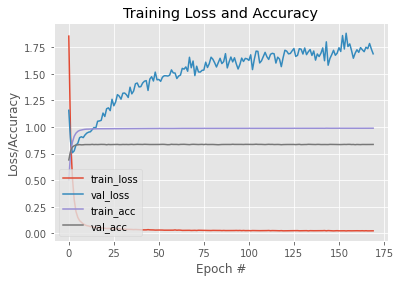

In [ ]:
plt.style.use("ggplot")

plt.figure()

plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot(hist.history["categorical_accuracy"], label="train_acc")
plt.plot(hist.history["val_categorical_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

- Accuracy: 84.18%
- Specifity: 99.54%
- Sensitivity: 77.6%
- Precision: 82.72%
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        97
           1       1.00      0.43      0.60         7
           2       0.73      0.69      0.71       153
           3       0.78      0.72      0.75       576
           4       0.59      0.63      0.61       176
           5       0.85      0.81      0.83      1612
           6       0.79      0.84      0.82       752
           7       0.88      0.88      0.88       192
           8       0.85      0.85      0.85       694
           9       0.77      0.67      0.72       791
          10       0.96      0.94      0.95      3896
          11       0.93      0.85      0.89       320
          12       0.85      0.76      0.80        45
          13       0.67      0.82      0.74        17
          14       0.89      0.88      0.89       536
          15       0.97      0.95      0.96       283
 

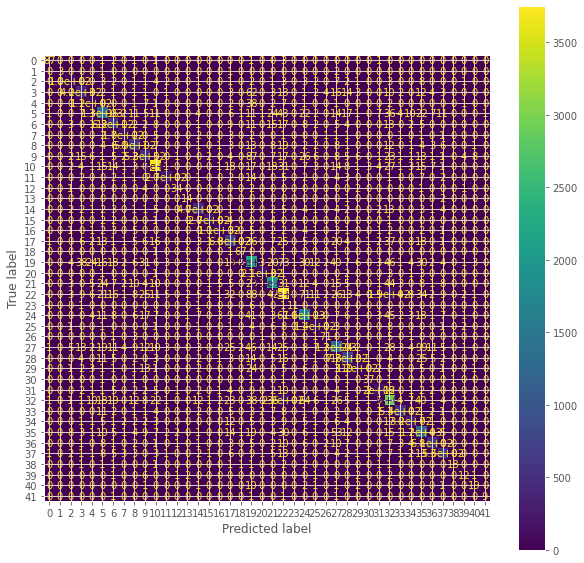

In [ ]:
stage1.get_metrics()

In [31]:
K.clear_session()

model = Sequential()

model.add(Reshape(input_shape=(6051, ), target_shape=(6051, 1)))
model.add(Conv1D(filters=128,kernel_size=4, activation = "relu"))
model.add(Conv1D(filters=128,kernel_size=4, activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256,kernel_size=3, activation = "relu"))
model.add(Conv1D(filters=256,kernel_size=3, activation = "relu"))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())
model.add(Dense(512, activation = "relu"))
model.add(Dense(256, activation = "relu"))
model.add(Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 6051, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6048, 128)         640       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6045, 128)         65664     
_________________________________________________________________
batch_normalization (BatchNo (None, 6045, 128)         512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3022, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3020, 256)         98560     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3018, 256)         1

In [32]:
hist = model.fit(stage1.x_train ,stage1.y_train, epochs=170, validation_data=(stage1.x_val, stage1.y_val), batch_size=500)

Epoch 1/170


TypeError: ignored